In [ ]:
#Récupération des données
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Chemin vers ton dossier INCEpTION dans ton Drive
tsv_dir = "/content/drive/MyDrive/annotation100/"


Mounted at /content/drive


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
!pip install -q transformers datasets scikit-learn

In [ ]:
#Extraire les lables depuis Inception
import os
import re
from collections import Counter

def clean_raw_label(label):
    label = label.strip()
    label = re.sub(r"\[\d+\]", "", label)  # supprime les [1], [2], etc.
    label = label.replace("\\_", "_")
    return label

def collect_all_raw_labels(tsv_root):
    label_counter = Counter()
    files_checked = 0

    for root, _, files in os.walk(tsv_root):
        for file in files:
            if file == "MBY3.tsv":
                path = os.path.join(root, file)
                files_checked += 1
                with open(path, encoding="utf-8") as f:
                    for line in f:
                        if line.startswith("#") or not line.strip():
                            continue
                        parts = line.strip().split("\t")
                        if len(parts) >= 4:
                            raw_label = parts[3]
                            if raw_label and raw_label != "_":
                                cleaned = clean_raw_label(raw_label)
                                label_counter[cleaned] += 1

    print(f"🔍 Fichiers analysés : {files_checked}")
    return label_counter

# 🔥 Appel
label_counter = collect_all_raw_labels(tsv_dir)

# 📊 Afficher tous les labels trouvés
print("\n📌 Labels trouvés dans les exports INCEpTION :\n")
for label, count in label_counter.most_common():
    print(f"{label} : {count} occurences")


🔍 Fichiers analysés : 101

📌 Labels trouvés dans les exports INCEpTION :

Conflit : 512 occurences
Décision gouvernementale : 439 occurences
Avancée technologique : 175 occurences
Évenement culturelle : 91 occurences
Décès : 52 occurences
Conflit politique : 17 occurences
* : 9 occurences
Government_Decision : 1 occurences


In [ ]:
import os
import re

def clean_raw_label(label):
    return re.sub(r"\[\d+\]", "", label.strip()).replace("\\_", "_")

def find_label_in_files(tsv_root, target_label):
    matching_files = []
    files_checked = 0
    normalized_target = clean_raw_label(target_label)

    for root, _, files in os.walk(tsv_root):
        for file in files:
            if file == "MBY3.tsv":
                path = os.path.join(root, file)
                files_checked += 1
                with open(path, encoding="utf-8") as f:
                    for line in f:
                        if line.startswith("#") or not line.strip():
                            continue
                        parts = line.strip().split("\t")
                        if len(parts) >= 4:
                            raw_label = parts[3]
                            cleaned_label = clean_raw_label(raw_label)
                            if cleaned_label == normalized_target:
                                matching_files.append(path)
                                break  # pas besoin de lire tout le fichier
    return matching_files, files_checked

# 📥 Paramètres
tsv_root = tsv_dir  # <-- adapte à ton chemin
label_to_find = "*"

# 🔍 Rechercher
found_files, total = find_label_in_files(tsv_root, label_to_find)

print(f"🔍 Label recherché : \"{label_to_find}\"")
print(f"🔎 Fichiers analysés : {total}")
if found_files:
    print("📁 Trouvé dans les fichiers :")
    for f in found_files:
        print("-", f)
else:
    print("✅ Aucun fichier ne contient ce label.")


🔍 Label recherché : "*"
🔎 Fichiers analysés : 101
📁 Trouvé dans les fichiers :
- /content/drive/MyDrive/annotation100/text_15.txt/MBY3.tsv
- /content/drive/MyDrive/annotation100/text_43.txt/MBY3.tsv
- /content/drive/MyDrive/annotation100/text_40.txt/MBY3.tsv
- /content/drive/MyDrive/annotation100/text_51.txt/MBY3.tsv
- /content/drive/MyDrive/annotation100/text_63.txt/MBY3.tsv


In [ ]:
import os
import re
from datasets import Dataset

# 🎯 Remap des labels spécifiques à corriger
LABEL_REMAP = {
    "Government_Decision": "Décision gouvernementale",
    "Conflit politique": "Conflit",
    "*": "O",
    "B-*": "O",
    "I-*": "O",
}

# ✅ Labels valides attendus depuis INCEpTION
ALLOWED_LABELS = {
    "Avancée technologique",
    "Conflit",
    "Décès",
    "Décision gouvernementale",
    "Évenement culturelle"
}

def normalize_label(label):
    # Nettoyage des indices [1], [2], etc.
    label = re.sub(r"\[\d+\]", "", label).strip()
    label = LABEL_REMAP.get(label, label)

    # Si label BIO (B- ou I-), vérifier la base
    if label.startswith("B-") or label.startswith("I-"):
        prefix = label[:2]
        base = label[2:].strip()
        base = LABEL_REMAP.get(base, base)
        if base in ALLOWED_LABELS:
            return f"{prefix}{base}"
        else:
            return "O"

    # Label simple autorisé → on force B- (au cas où)
    if label in ALLOWED_LABELS:
        return f"B-{label}"

    if label == "O":
        return "O"

    return "O"

def parse_and_correct_tsv(tsv_path):
    sentences = []
    sentence = []
    labels = []
    label_seq = []
    current_entity = None

    with open(tsv_path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            if line.startswith("#Text="):
                if sentence:
                    sentences.append(sentence)
                    labels.append(label_seq)
                    sentence, label_seq = [], []
                continue

            if not line or line.startswith("#"):
                continue

            parts = line.split("\t")
            if len(parts) < 4:
                continue

            token = parts[2]
            raw_label = parts[3]
            clean = normalize_label(raw_label)

            if clean == "O":
                label = "O"
                current_entity = None
            else:
                if current_entity == clean[2:]:
                    label = f"I-{clean[2:]}"
                else:
                    label = clean
                    current_entity = clean[2:]

            sentence.append(token)
            label_seq.append(label)

    if sentence:
        sentences.append(sentence)
        labels.append(label_seq)

    return {"tokens": sentences, "labels": labels}

def process_all_tsv(tsv_dir):
    all_tokens = []
    all_labels = []
    for root, _, files in os.walk(tsv_dir):
        for file in files:
            if file == "MBY3.tsv":
                result = parse_and_correct_tsv(os.path.join(root, file))
                all_tokens.extend(result["tokens"])
                all_labels.extend(result["labels"])
    return Dataset.from_dict({"tokens": all_tokens, "labels": all_labels})


In [ ]:
dataset = process_all_tsv(tsv_dir)

# Optionnel : sauvegarde
dataset.save_to_disk("/content/event_dataset_inception_style")

# 🔍 Vérification des labels
from collections import Counter
label_counter = Counter(label for row in dataset for label in row["labels"])
print("\n📊 Répartition des labels :")
for label, count in label_counter.most_common():
    print(f"{label:30s} : {count}")


Saving the dataset (0/1 shards):   0%|          | 0/1053 [00:00<?, ? examples/s]


📊 Répartition des labels :
O                              : 23510
B-Conflit                      : 301
B-Décision gouvernementale     : 232
I-Conflit                      : 228
I-Décision gouvernementale     : 207
I-Avancée technologique        : 95
B-Avancée technologique        : 80
I-Évenement culturelle         : 55
B-Évenement culturelle         : 36
B-Décès                        : 35
I-Décès                        : 17


In [ ]:
from datasets import DatasetDict

# Split 90% train / 10% test
dataset_split = dataset.train_test_split(test_size=0.1, seed=42)
dataset_split = DatasetDict({
    "train": dataset_split["train"],
    "test": dataset_split["test"]
})

print(f"📊 Train set : {len(dataset_split['train'])} exemples")
print(f"📊 Test set  : {len(dataset_split['test'])} exemples")


📊 Train set : 947 exemples
📊 Test set  : 106 exemples


In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", force_download=True)


OSError: Can't load tokenizer for 'bert-base-uncased'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'bert-base-uncased' is the correct path to a directory containing all relevant files for a BertTokenizerFast tokenizer.

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Extraire les labels uniques
unique_labels = sorted({label for row in dataset for label in row["labels"]})
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

print("📌 label2id :", label2id)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: Can't load tokenizer for 'bert-base-uncased'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'bert-base-uncased' is the correct path to a directory containing all relevant files for a BertTokenizerFast tokenizer.

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    labels_batch = []

    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        labels = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(label2id[examples["labels"][i][word_idx]])
            else:
                labels.append(label2id[examples["labels"][i][word_idx]])  # ou -100 pour ignorer sous-tokens
            previous_word_idx = word_idx

        labels_batch.append(labels)

    tokenized_inputs["labels"] = labels_batch
    return tokenized_inputs

# 🔁 Application sur le dataset
tokenized_dataset = dataset_split.map(tokenize_and_align_labels, batched=True)
# 🔥 Supprimer les colonnes textuelles qui bloquent le Trainer
tokenized_dataset = tokenized_dataset.remove_columns(["tokens"])
print("✅ Tokenisation + alignement terminés !")


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

✅ Tokenisation + alignement terminés !


In [ ]:
print(tokenized_dataset["train"].column_names)

['labels', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
from sklearn.metrics import classification_report
import numpy as np

# ✅ Chargement du modèle avec correspondance des labels
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# ✅ Préparation du collator pour gérer le padding dans les batchs
data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

# ✅ Fonction pour calculer precision / recall / f1-score
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=2)

    true_preds = []
    true_labels = []

    for pred_seq, label_seq in zip(preds, labels):
        for p_, l_ in zip(pred_seq, label_seq):
            if l_ != -100:
                true_preds.append(id2label[p_])
                true_labels.append(id2label[l_])

    report = classification_report(true_labels, true_preds, output_dict=True)
    return {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"]
    }


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

# ✅ Arguments d'entraînement compatibles avec versions < 5
training_args = TrainingArguments(
    output_dir="/content/event_model",             # Où sauvegarder le modèle
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="/content/logs",                   # Logs pour TensorBoard (facultatif)
    logging_steps=10,
    report_to="none",                              # Désactive wandb, tensorboard, etc.
    remove_unused_columns=False,                   # Important pour les tâches token classification
    do_eval=True                                   # Active l'évaluation à chaque epoch
)

# ✅ Trainer Hugging Face
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,                           # OK pour versions < 5
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 🚀 Lancer l'entraînement
trainer.train()


<ipython-input-19-c05f185ea810>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.032300
20,0.029100
30,0.023400
40,0.024000
50,0.022400
60,0.029700
70,0.021300
80,0.016700
90,0.012500
100,0.010300


TrainOutput(global_step=152, training_loss=0.017621763552980202, metrics={'train_runtime': 37.8722, 'train_samples_per_second': 31.791, 'train_steps_per_second': 4.013, 'total_flos': 78656723432448.0, 'train_loss': 0.017621763552980202, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.4900329113006592,
 'eval_precision': 0.37225532754538276,
 'eval_recall': 0.23123678762122699,
 'eval_f1': 0.2754881992656023,
 'eval_runtime': 0.3499,
 'eval_samples_per_second': 97.178,
 'eval_steps_per_second': 14.291,
 'epoch': 4.0}

In [ ]:
from transformers import pipeline

# ✅ Création du pipeline avec ton modèle entraîné
ner_pipeline = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"  # groupe les tokens sous une même entité
)

# 📝 Texte anglais à tester
text = "The government announced a new technology in response to the recent conflict."

# 🔍 Prédictions du modèle
outputs = ner_pipeline(text)

# 📦 Affichage clair
print("\n🔎 Résultats NER :\n")
for ent in outputs:
    print(f"{ent['word']} → {ent['entity_group']} (score: {ent['score']:.2f})")


Device set to use cuda:0



🔎 Résultats NER :



In [ ]:
texts = [
    "The president died yesterday in an unexpected accident.",
    "Firefox 1.0 has been released with innovative features.",
    "The UN announced new cultural events in New York."
]

for t in texts:
    print(f"\n📝 {t}")
    results = ner_pipeline(t)
    for ent in results:
        print(f"{ent['word']} → {ent['entity_group']} (score: {ent['score']:.2f})")



📝 The president died yesterday in an unexpected accident.
died → Décès (score: 0.57)

📝 Firefox 1.0 has been released with innovative features.
1 → Avancée technologique (score: 0.49)
. → Avancée technologique (score: 0.59)
0 → Avancée technologique (score: 0.59)

📝 The UN announced new cultural events in New York.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


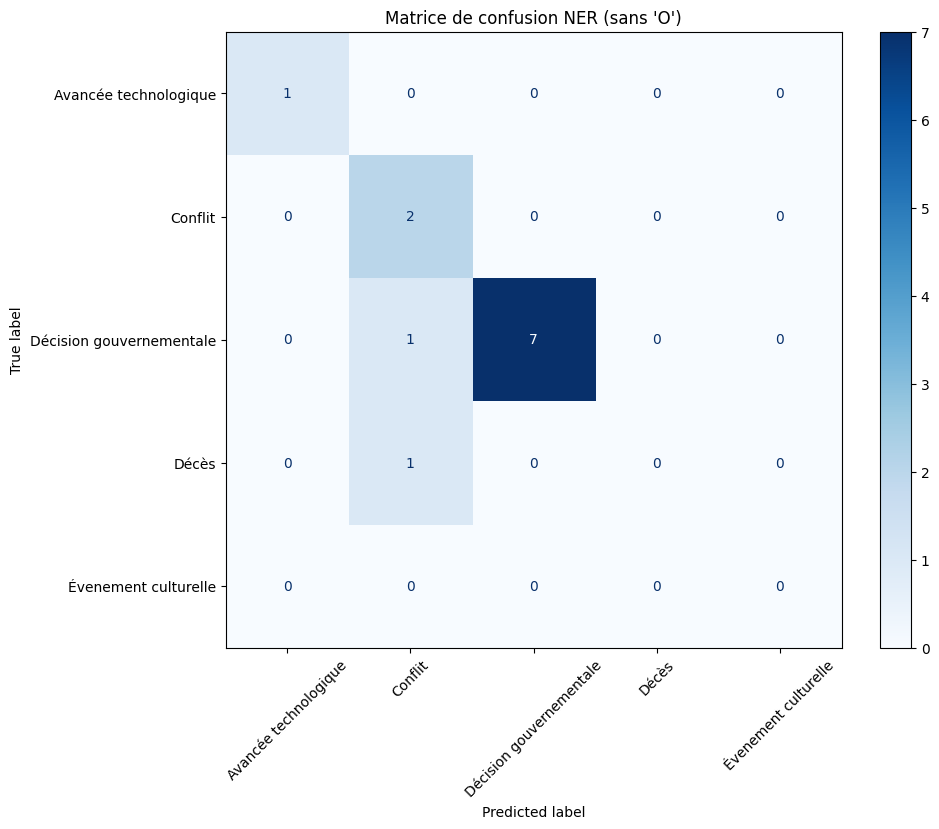

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 🔁 Obtenir les prédictions du modèle
output = trainer.predict(tokenized_dataset["test"])
predictions = output.predictions
labels = output.label_ids

preds = np.argmax(predictions, axis=2)

# 🔍 Extraire les vrais/preds labels (en texte), sans les -100
true_labels = []
true_preds = []

for pred_seq, label_seq in zip(np.argmax(predictions, axis=2), labels):
    for p, l in zip(pred_seq, label_seq):
        if l != -100:
          pred_label = id2label[p]
          true_label = id2label[l]

          # 🔄 Supprimer les préfixes B-/I-
          pred_label = pred_label.replace("B-", "").replace("I-", "")
          true_label = true_label.replace("B-", "").replace("I-", "")

          if true_label != "O":
            true_preds.append(pred_label)
            true_labels.append(true_label)

# ✅ Liste des labels à afficher sans "O"
label_names = list(set(true_labels))  # toutes les entités après simplification
label_names.sort()

# 📊 Créer la matrice
cm = confusion_matrix(true_labels, true_preds, labels=label_names)

# 🎨 Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matrice de confusion NER (sans 'O')")
plt.show()


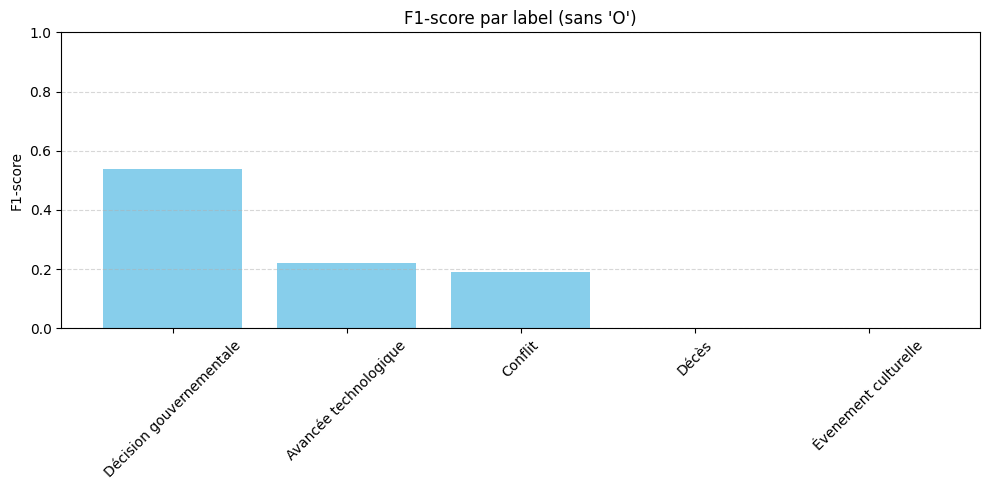

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Calculer le rapport
report = classification_report(true_labels, true_preds, labels=label_names, output_dict=True, zero_division=0)

# Extraire les scores F1 par entité uniquement
f1_scores = {label: values['f1-score'] for label, values in report.items() if label in label_names}

# Trier par score
f1_scores = dict(sorted(f1_scores.items(), key=lambda x: x[1], reverse=True))

# 🎨 Barplot
plt.figure(figsize=(10, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.ylabel("F1-score")
plt.title("F1-score par label (sans 'O')")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
trainer.save_model("/content/event_model_final")
tokenizer.save_pretrained("/content/event_model_final")


('/content/event_model_final/tokenizer_config.json',
 '/content/event_model_final/special_tokens_map.json',
 '/content/event_model_final/vocab.txt',
 '/content/event_model_final/added_tokens.json',
 '/content/event_model_final/tokenizer.json')

In [ ]:
!zip -r /content/event_model_final.zip /content/event_model_final

  adding: content/event_model_final/ (stored 0%)
  adding: content/event_model_final/config.json (deflated 61%)
  adding: content/event_model_final/vocab.txt (deflated 53%)
  adding: content/event_model_final/special_tokens_map.json (deflated 42%)
  adding: content/event_model_final/tokenizer_config.json (deflated 75%)
  adding: content/event_model_final/training_args.bin (deflated 52%)
  adding: content/event_model_final/model.safetensors (deflated 7%)
  adding: content/event_model_final/tokenizer.json (deflated 71%)


In [ ]:
from google.colab import files
files.download("/content/event_model_final.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Pour recharger le modèle
from transformers import AutoTokenizer, AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/chemin/vers/event_model_final")
tokenizer = AutoTokenizer.from_pretrained("/chemin/vers/event_model_final")

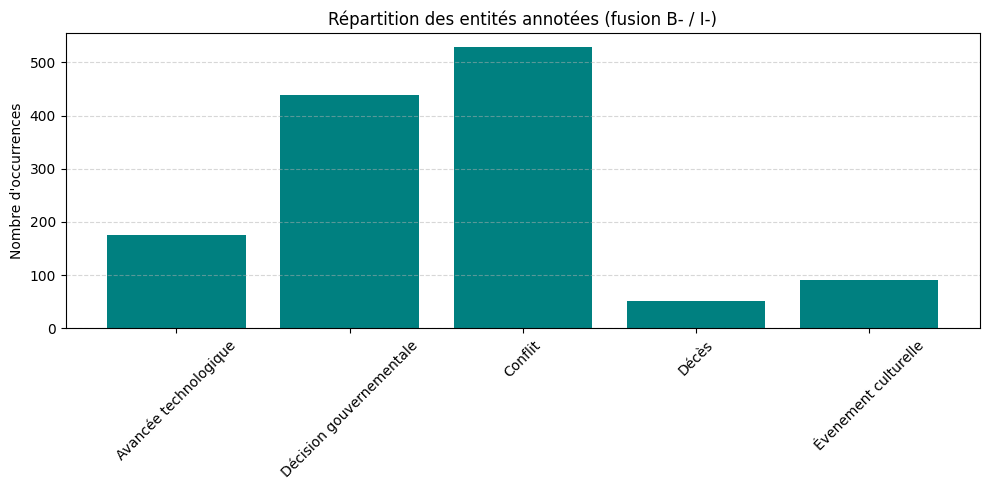

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# 🔄 Compter les labels en fusionnant B- et I-
entity_counter = Counter()

for example in dataset:
    for label in example["labels"]:
        if label != "O":
            base_label = label.replace("B-", "").replace("I-", "")
            entity_counter[base_label] += 1

# 📦 Préparer les données
labels = list(entity_counter.keys())
counts = list(entity_counter.values())

# 🎨 Affichage du barplot
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='teal')
plt.title("Répartition des entités annotées (fusion B- / I-)")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


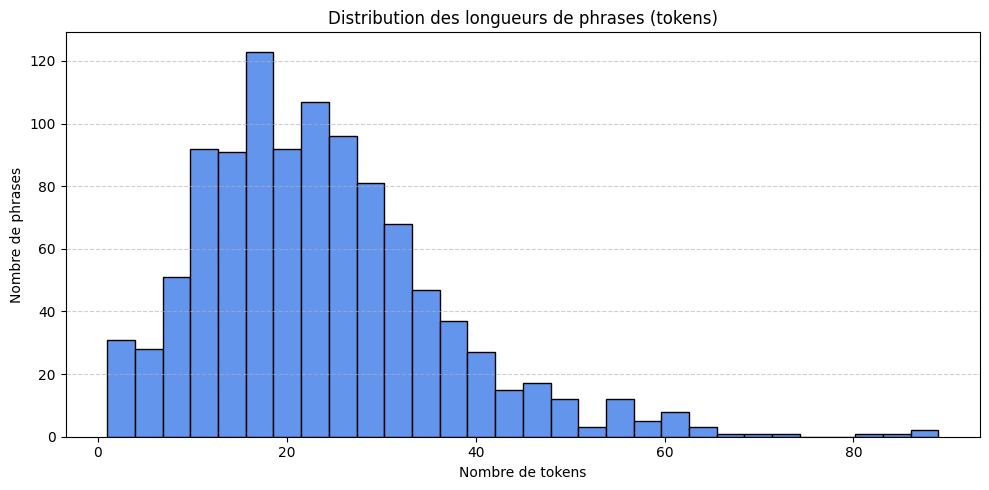

In [ ]:
lengths = [len(example["tokens"]) for example in dataset]

plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=30, color='cornflowerblue', edgecolor='black')
plt.title("Distribution des longueurs de phrases (tokens)")
plt.xlabel("Nombre de tokens")
plt.ylabel("Nombre de phrases")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


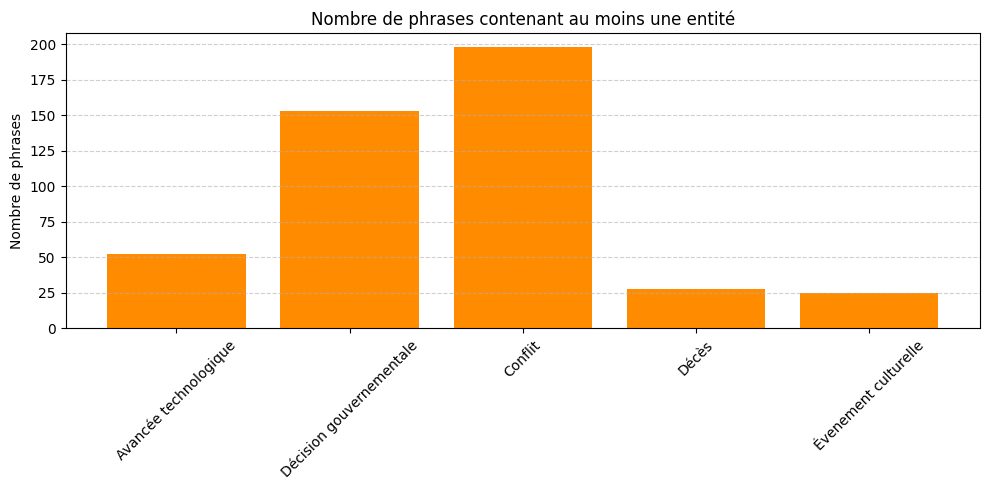

In [ ]:
phrase_level_counter = Counter()

for example in dataset:
    labels_in_sentence = set(
        label.replace("B-", "").replace("I-", "")
        for label in example["labels"]
        if label != "O"
    )
    for label in labels_in_sentence:
        phrase_level_counter[label] += 1

labels = list(phrase_level_counter.keys())
counts = list(phrase_level_counter.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='darkorange')
plt.title("Nombre de phrases contenant au moins une entité")
plt.ylabel("Nombre de phrases")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import display, HTML

# Fonction pour colorer les entités dans une phrase
def highlight_entities(tokens, labels):
    html = ""
    current_label = None

    for token, label in zip(tokens, labels):
        base_label = label.replace("B-", "").replace("I-", "") if label != "O" else None
        if label.startswith("B-") or (label.startswith("I-") and current_label != base_label):
            if current_label:
                html += "</span> "
            html += f'<span style="background-color: blue; padding:2px; border-radius:3px;"><strong>{token}</strong>'
            current_label = base_label
        elif label.startswith("I-") and base_label == current_label:
            html += f' {token}'
        else:
            if current_label:
                html += "</span> "
                current_label = None
            html += f"{token} "

    if current_label:
        html += "</span>"

    return html

# Choisir un exemple contenant au moins une entité
example = next(e for e in dataset if any(l != "O" for l in e["labels"]))
display(HTML(highlight_entities(example["tokens"], example["labels"])))


In [ ]:
import json

# Créer une version exploitable pour R (phrases + labels)
export_data = [{"tokens": ex["tokens"], "labels": ex["labels"]} for ex in dataset]

# Sauvegarde locale dans ta session Colab
with open("ner_data.json", "w", encoding="utf-8") as f:
    json.dump(export_data, f, ensure_ascii=False, indent=2)


# Similarité de jacard


Matrice de similarité :
[[1.         0.14285714 0.11111111 ... 0.         0.         0.42857143]
 [0.14285714 1.         0.14285714 ... 0.         0.         0.14285714]
 [0.11111111 0.14285714 1.         ... 0.         0.         0.11111111]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.42857143 0.14285714 0.11111111 ... 0.         0.         1.        ]]


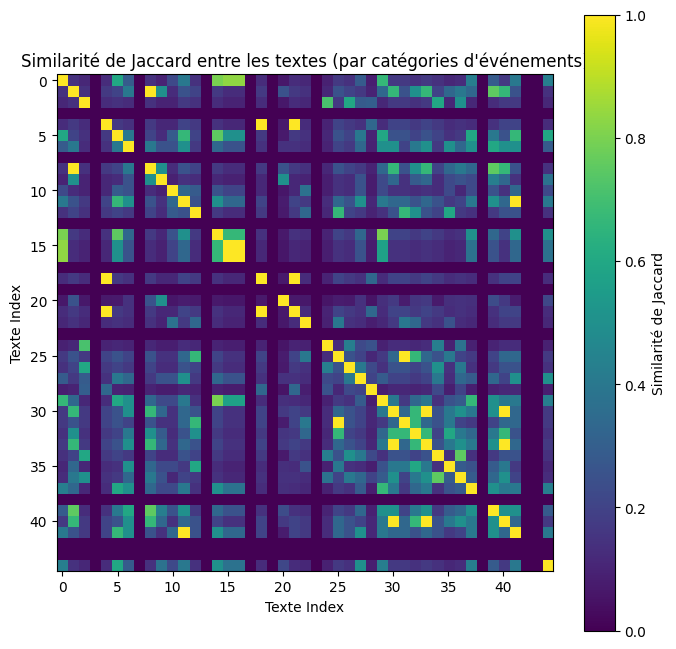

In [ ]:
import os
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def clean_raw_label(label):
    """Nettoie les labels bruts (comme tu le faisais déjà)."""
    return re.sub(r"\\[\d+\\]", "", label.strip()).replace("\\_", "_")

def extract_event_categories_from_tsv(tsv_path):
    """
    Extrait l'ensemble unique des catégories d'événements d'un fichier TSV.

    Args:
        tsv_path (str): Chemin vers le fichier TSV.

    Returns:
        set: Un ensemble de chaînes représentant les catégories d'événements.
    """

    event_categories = set()
    with open(tsv_path, encoding="utf-8") as f:
        for line in f:
            if line.startswith("#") or not line.strip():
                continue
            parts = line.strip().split("\t")
            if len(parts) >= 4:
                raw_label = parts[3]
                cleaned_label = clean_raw_label(raw_label)
                if cleaned_label != "O" and cleaned_label:  # Exclure 'O' et les labels vides
                    event_categories.add(cleaned_label)
    return event_categories

def process_all_tsv_in_dir(tsv_dir):
    """
    Parcourt tous les fichiers TSV dans un répertoire et extrait les catégories d'événements.

    Args:
        tsv_dir (str): Chemin vers le répertoire contenant les fichiers TSV.

    Returns:
        list: Une liste d'ensembles, où chaque ensemble représente les catégories d'un fichier TSV.
    """

    all_categories = []
    for root, _, files in os.walk(tsv_dir):
        for file in files:
            if file == "MBY3.tsv":  # Ou toute autre condition pour sélectionner tes fichiers
                tsv_path = os.path.join(root, file)
                categories = extract_event_categories_from_tsv(tsv_path)
                all_categories.append(categories)
    return all_categories

def jaccard_similarity(A, B):
    intersection = len(A.intersection(B))
    union = len(A.union(B))
    if union == 0:
        return 0.0
    else:
        return intersection / union

# 1. Extraction des catégories depuis les fichiers TSV
tsv_dir = "/content/drive/MyDrive/annotation/"  # Remplace par le chemin de ton dossier
all_text_categories = process_all_tsv_in_dir(tsv_dir)

# 2. Calcul des similarités
num_texts = len(all_text_categories)
similarity_matrix = np.zeros((num_texts, num_texts))

for i in range(num_texts):
    for j in range(num_texts):
        similarity_matrix[i, j] = jaccard_similarity(all_text_categories[i], all_text_categories[j])

print("\nMatrice de similarité :")
print(similarity_matrix)

# 3. Visualisation (exemple)
plt.figure(figsize=(8, 8))
plt.imshow(similarity_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Similarité de Jaccard")
plt.title("Similarité de Jaccard entre les textes (par catégories d'événements)")
plt.xlabel("Texte Index")
plt.ylabel("Texte Index")
plt.show()

In [ ]:
import os
import re
from collections import defaultdict

def clean_raw_label(label):
    label = label.strip()
    label = re.sub(r"\[\d+\]", "", label)  # supprime les [1], [2], etc.
    label = label.replace("\\_", "_")
    return label

def build_text_event_mapping(tsv_root):
    text_events = defaultdict(set)

    for root, _, files in os.walk(tsv_root):
        for file in files:
            if file == "MBY3.tsv":
                text_id = os.path.basename(root)
                path = os.path.join(root, file)
                with open(path, encoding="utf-8") as f:
                    for line in f:
                        if line.startswith("#") or not line.strip():
                            continue
                        parts = line.strip().split("\t")
                        if len(parts) >= 4:
                            raw_label = parts[3]
                            if raw_label and raw_label != "_":
                                cleaned = clean_raw_label(raw_label)
                                text_events[text_id].add(cleaned)
    return text_events

# 🔁 Lance ça avec ton chemin réel
tsv_root = "/content/drive/MyDrive/annotation100"
text_events = build_text_event_mapping(tsv_root)


In [ ]:
import pandas as pd
from itertools import combinations

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

text_ids = list(text_events.keys())
similarity_matrix = pd.DataFrame(index=text_ids, columns=text_ids, dtype=float)

for id1, id2 in combinations(text_ids, 2):
    sim = jaccard_similarity(text_events[id1], text_events[id2])
    similarity_matrix.loc[id1, id2] = sim
    similarity_matrix.loc[id2, id1] = sim

for id in text_ids:
    similarity_matrix.loc[id, id] = 1.0

# 📊 Afficher un aperçu
similarity_matrix.head()


,article_20.txt,article_17.txt,article_16.txt,article_23.txt,article_22.txt,article_19.txt,article_21.txt,text_11.txt,article_26.txt,article_30.txt,...,text_87.txt,text_83.txt,text_97.txt,text_92.txt,text_98.txt,text_90.txt,text_9.txt,text_96.txt,text_91.txt,text_99.txt
article_20.txt,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,1.0,0.000000,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0
article_17.txt,0.0,1.0,0.5,1.0,0.0,1.0,0.500000,0.0,1.0,0.0,...,0.500000,0.0,0.500000,0.0,1.0,0.500000,1.0,0.0,0.500000,1.0
article_16.txt,0.0,0.5,1.0,0.5,0.0,0.5,0.333333,0.0,0.5,0.0,...,0.333333,0.0,0.333333,0.0,0.5,0.333333,0.5,0.0,0.333333,0.5
article_23.txt,0.0,1.0,0.5,1.0,0.0,1.0,0.500000,0.0,1.0,0.0,...,0.500000,0.0,0.500000,0.0,1.0,0.500000,1.0,0.0,0.500000,1.0
article_22.txt,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0


In [ ]:
!pip install -q upsetplot


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/usr/local/lib/python3.11/dist-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/

<Figure size 1000x600 with 0 Axes>

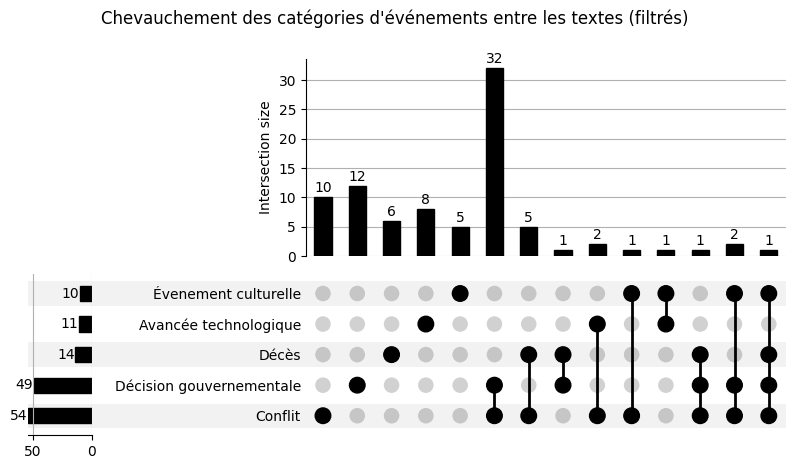

In [ ]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

# 🚫 Événements à ignorer
events_to_exclude = {"*", "Conflit politique", "Government_Decision"}

# 🔄 Nettoyage des événements dans chaque texte
text_events_cleaned = {
    k: {e for e in v if e not in events_to_exclude}
    for k, v in text_events.items()
}

# 🔄 Construire une liste des combinaisons d'événements filtrés
memberships = [tuple(sorted(events)) for events in text_events_cleaned.values() if events]
data = from_memberships(memberships)

# 📈 UpSet plot
plt.figure(figsize=(10,6))
UpSet(data, subset_size='count', show_counts=True).plot()
plt.suptitle("Chevauchement des catégories d'événements entre les textes (filtrés)")
plt.show()
